Using TensorFlow backend.


Epoch 1/5
3328/3346 [============================>.] - ETA: 0s - loss: 0.5325

/Users/takashi/.pyenv/versions/anaconda3-4.3.1/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


3392/3346 [==============================] - 55s - loss: 0.5230 - val_loss: 0.0308
Epoch 2/5
3364/3346 [==============================] - 54s - loss: 0.0234 - val_loss: 0.0246
Epoch 3/5
3392/3346 [==============================] - 56s - loss: 0.0206 - val_loss: 0.0180
Epoch 4/5
3364/3346 [==============================] - 54s - loss: 0.0197 - val_loss: 0.0184
Epoch 5/5
3392/3346 [==============================] - 54s - loss: 0.0186 - val_loss: 0.0165
dict_keys(['val_loss', 'loss'])


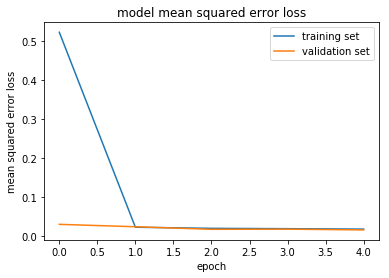

In [1]:
%matplotlib inline
import csv
import cv2
import numpy as np

lines = []
with open('../data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

import sklearn.utils
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(lines, test_size=0.2)

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1:
        sklearn.utils.shuffle(samples, random_state=20)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = '../data/IMG/' + batch_sample[0].split('/')[-1]
                center_image = cv2.imread(name)
                center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)
                images.append(cv2.flip(center_image, 1))
                angles.append(center_angle*-1.0)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train, random_state=20)

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

#
# correction = 0.2
#
# def add_images_measurements(image_path, steering_delta, images, measurements):
#     filename = image_path.split('/')[-1]
#     current_path = '../data/IMG/' + filename
#     image = cv2.imread(current_path)
#     images.append(image)
#     measurement = float(line[3])
#     measurements.append(measurement+ steering_delta)
#
# images = []
# measurements = []
# for line in lines:
#     add_images_measurements(line[0],           0, images, measurements) # center
#     # add_images_measurements(line[1],  correction, images, measurements) # left
#     # add_images_measurements(line[2], -correction, images, measurements) # right
#
#
# augmented_images, augmented_measurements = [], []
# for image, measurement in zip(images, measurements):
#     augmented_images.append(image)
#     augmented_measurements.append(measurement)
#     augmented_images.append(cv2.flip(image, 1))
#     augmented_measurements.append(measurement*-1.0)
#
# X_train = np.array(augmented_images)
# y_train = np.array(augmented_measurements)

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout, Activation, Cropping2D
from keras.layers import Convolution2D
from keras.layers.pooling import MaxPooling2D

#https://faroit.github.io/keras-docs/1.0.1/layers/convolutional/#convolution2d

model= Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160, 320, 3)))
model.add(Cropping2D(cropping=((70, 25), (0, 0))))
model.add(Convolution2D(6,5,5, activation="relu"))
model.add(MaxPooling2D())
model.add(Convolution2D(6,5,5, activation="relu"))
model.add(MaxPooling2D())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(120))
model.add(Dense(84))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
# history_object = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=5, verbose=1)
history_object = model.fit_generator(train_generator, samples_per_epoch = len(train_samples),
        validation_data = validation_generator, nb_val_samples = len(validation_samples), nb_epoch=5, verbose=1)

model.save('model.h5')

print(history_object.history.keys())

import matplotlib.pyplot as plt

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

        
